In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub


In [2]:
def get_model(model_url, max_seq_length):
  labse_layer = hub.KerasLayer(model_url, trainable=True)

  # Define input.
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                     name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")

  # LaBSE layer.
  pooled_output,  _ = labse_layer([input_word_ids, input_mask, segment_ids])

  # The embedding is l2 normalized.
  pooled_output = tf.keras.layers.Lambda(
      lambda x: tf.nn.l2_normalize(x, axis=1))(pooled_output)

  # Define model.
  return tf.keras.Model(
        inputs=[input_word_ids, input_mask, segment_ids],
        outputs=pooled_output), labse_layer

max_seq_length = 64
labse_model, labse_layer = get_model(
    model_url="https://tfhub.dev/google/LaBSE/1", max_seq_length=max_seq_length)


In [7]:
!pip install bert-for-tf2

     |████████████████████████████████| 41 kB 126 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=3922f9c23cd552ec22e68d964b1697e951646c38607852eb438ed4d55f87cc34
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=996f1cd7ba12d13d0022c88726a05afe7050f2e4f2210033ef0681baa103f263
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7912 sha256=20184a19bae3aa4a4d1fb6563aeb19fc9da4492e7b9a34e4329869ef2b59d368
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [8]:
import bert

vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [9]:
def create_input(input_strings, tokenizer, max_seq_length):

  input_ids_all, input_mask_all, segment_ids_all = [], [], []
  for input_string in input_strings:
    # Tokenize input.
    input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
    sequence_length = min(len(input_ids), max_seq_length)

    # Padding or truncation.
    if len(input_ids) >= max_seq_length:
      input_ids = input_ids[:max_seq_length]
    else:
      input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

    input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

    input_ids_all.append(input_ids)
    input_mask_all.append(input_mask)
    segment_ids_all.append([0] * max_seq_length)

  return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)

def encode(input_text):
  input_ids, input_mask, segment_ids = create_input(
    input_text, tokenizer, max_seq_length)
  return labse_model([input_ids, input_mask, segment_ids])

english_sentences = ["dog", "Puppies are nice.", "I enjoy taking long walks along the beach with my dog."]
italian_sentences = ["cane", "I cuccioli sono carini.", "Mi piace fare lunghe passeggiate lungo la spiaggia con il mio cane."]
japanese_sentences = ["犬", "子犬はいいです", "私は犬と一緒にビーチを散歩するのが好きです"]

english_embeddings = encode(english_sentences)
italian_embeddings = encode(italian_sentences)
japanese_embeddings = encode(japanese_sentences)

# English-Italian similarity
print (np.matmul(english_embeddings, np.transpose(italian_embeddings)))

# English-Japanese similarity
print (np.matmul(english_embeddings, np.transpose(japanese_embeddings)))

# Italian-Japanese similarity
print (np.matmul(italian_embeddings, np.transpose(japanese_embeddings)))

[[0.631929   0.3061978  0.4429748 ]
 [0.11652686 0.8596665  0.35940558]
 [0.14803982 0.32447964 0.954265  ]]
[[0.9356719  0.5403067  0.46792307]
 [0.31804207 0.76222515 0.36085895]
 [0.36750704 0.42791533 0.81714535]]
[[0.53437203 0.2501862  0.19974726]
 [0.30140823 0.71333206 0.40647542]
 [0.3850307  0.47767884 0.86742985]]


In [10]:
from google.colab import files
uploaded = files.upload()

Saving Multilingual_data.csv to Multilingual_data.csv


In [11]:
import io
import pandas as pd
df = pd.read_csv(io.StringIO(uploaded['Multilingual_data.csv'].decode('utf-8')))
df

,English,German,French,Spanish
0,I have practiced piano every day for fifteen y...,Ich habe fÃ¼nfzehn Jahre lang jeden Tag Klavie...,Je pratique le piano tous les jours depuis qui...,He practicado el piano todos los dÃ­as durante...
1,What flower do you like best?,Welche Blume magst du am liebsten?,Quelle fleur prÃ©fÃ©rez-vous?,Â¿QuÃ© flor te gusta mÃ¡s?
2,Spend your time wisely and you'll always have ...,Verbringen Sie Ihre Zeit mit Bedacht und Sie w...,Passez votre temps Ã bon escient et vous en a...,Pase su tiempo sabiamente y siempre tendrÃ¡ su...
3,"If you act like a child, you will be treated a...","Wenn Sie sich wie ein Kind verhalten, werden S...","Si vous agissez comme un enfant, vous serez tr...","Si actÃºas como un niÃ±o, serÃ¡s tratado como ..."
4,What do you think she is doing now?,"Was glaubst du, macht sie jetzt?",Que pensez-vous qu'elle fait maintenant?,Â¿QuÃ© crees que estÃ¡ haciendo ella ahora?
5,I hope you finish for work on time.,"Ich hoffe, Sie sind pÃ¼nktlich zur Arbeit fertig.",J'espÃ¨re que vous finirez Ã temps pour le tr...,Espero que termines tu trabajo a tiempo.
6,Please keep your mouth closed while you eat yo...,"Bitte halten Sie den Mund geschlossen, wÃ¤hren...",Veuillez garder la bouche fermÃ©e pendant que ...,"Â¡Por favor, mantenga la boca cerrada mientras..."
7,I suppose it's different when you think about ...,"Ich nehme an, es ist anders, wenn man langfris...",Je suppose que c'est diffÃ©rent quand on y pen...,Supongo que es diferente cuando lo piensas a l...
8,A burglar broke into your house while you were...,"Ein Einbrecher ist in Ihr Haus eingebrochen, a...",Un cambrioleur est entrÃ© par effraction dans ...,Un ladrÃ³n irrumpiÃ³ en su casa mientras estab...
9,I'm sorry to have kept you waiting.,"Tut mir leid, dass ich dich habe warten lassen.",Je suis dÃ©solÃ© de vous avoir fait attendre.,Siento haberte hecho esperar.


In [12]:
en = encode(list(df['English'])) 
german = encode(list(df['German']))
french = encode(list(df['French']))
spanish = encode(list(df['Spanish']))


In [13]:
en.shape

TensorShape([14, 768])

In [14]:
german.shape

TensorShape([14, 768])

In [15]:
french.shape

TensorShape([14, 768])

In [16]:
spanish.shape

TensorShape([14, 768])

In [17]:
from sklearn.decomposition import PCA
def lists_to_ARRAY(a,b,c,d): 
    a_stack = np.stack(a)
    b_stack = np.stack(b)
    c_stack = np.stack(c)
    d_stack = np.stack(d)
    ARRAY = np.concatenate((a_stack,b_stack,c_stack,d_stack),axis=0)
    pca = PCA(n_components=2)
    pca_out = pca.fit_transform(ARRAY)
    return(pca_out)

In [18]:
sent_ARRAY = lists_to_ARRAY(en,german,french,spanish)

In [19]:
sent_ARRAY.shape

(56, 2)

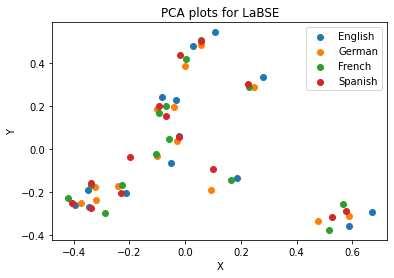

In [20]:
import matplotlib.pyplot as plt
plt.scatter(sent_ARRAY[:14,0],sent_ARRAY[:14,1],) 
plt.scatter(sent_ARRAY[14:28,0],sent_ARRAY[14:28,1])
plt.scatter(sent_ARRAY[28:42,0],sent_ARRAY[28:42,1])
plt.scatter(sent_ARRAY[42:56,0],sent_ARRAY[42:56,1])
plt.legend(['English','German','French','Spanish'])
plt.title('PCA plots for LaBSE')
plt.xlabel('X')
plt.ylabel('Y');

In [21]:
eval_sent1 = [['Hi my name is Uday'], #en
             ['Hola mi nombre es uday'], #es 
             ['Hallo, mein Name ist uday'],#German
            ['انا اسمي عدي']] #Arabic

eval_sent2 = [['movie was okish but actors were great'], #en
             ['la película estaba bien pero los actores eran geniales'], #es 
             ['Film war okisch, aber die Schauspieler waren großartig'],#German
            ['الفيلم كان طيب لكن الممثلين كانوا رائعين']] #Arabic

eval_sent3 = [['Is there a way I can return the product?'], #en
             ['Hay alguna forma de devolver el producto?'], #es 
             ['Kann ich das Produkt zurückgeben?'],#German
            ['هل هناك طريقة يمكنني إرجاع المنتج؟']] #Arabic

In [22]:
from itertools import combinations 
from sklearn.metrics.pairwise import cosine_similarity
def evaluate_embeddings(eval_sent):  #Takes a list of embeddings
    
    a = encode(eval_sent[0])
    b = encode(eval_sent[1])
    c = encode(eval_sent[2])
    d = encode(eval_sent[3])
    
    sent = [a,b,c,d]
    
    
    comb = combinations(sent, 2)
    similarities = []
    for i in list(comb): 
         similarities.extend(cosine_similarity(i[0],i[1])[0])
            
    return(similarities)

In [23]:
evaluate_embeddings(eval_sent1)


[0.90766597, 0.90984577, 0.78244746, 0.9660926, 0.73263973, 0.755973]

In [24]:
LaBSE_1 = evaluate_embeddings(eval_sent1)
LaBSE_2 = evaluate_embeddings(eval_sent2)
LaBSE_3 = evaluate_embeddings(eval_sent3)


([<matplotlib.axis.XTick at 0x7fb14e130ed0>,
 [Text(0, 0, "('a', 'b')"),
  Text(0, 0, "('a', 'c')"),
  Text(0, 0, "('a', 'd')"),
  Text(0, 0, "('b', 'c')"),
  Text(0, 0, "('b', 'd')"),
  Text(0, 0, "('c', 'd')")])

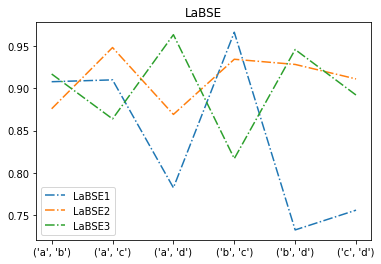

In [25]:
comb = combinations(['a','b','c','d'], 2)
import matplotlib.pyplot as plt
plt.plot(LaBSE_1,linestyle='dashdot')
plt.plot(LaBSE_2,linestyle='dashdot')
plt.plot(LaBSE_3,linestyle='dashdot')
plt.legend(['LaBSE1','LaBSE2','LaBSE3'])
plt.title('LaBSE')
plt.xticks(np.arange(0,6),comb)

In [26]:
en = [['Hi my name is Uday'], #en
              ['movie was okish but actors were great'],
              ['Is there a way I can return the product?']]

es = [['Hola mi nombre es Uday'], #es
             ['la película estaba bien pero los actores eran geniales'],
              ['Hay alguna forma de devolver el producto?']]

ger = [['Hallo, mein Name ist Uday'],
              ['Film war okisch, aber die Schauspieler waren großartig'],
              ['Kann ich das Produkt zurückgeben?']]
arab = [['انا اسمي عدي'],
              ['الفيلم كان طيب لكن الممثلين كانوا رائعين'],
              ['هل هناك طريقة يمكنني إرجاع المنتج؟']]

In [27]:
from itertools import combinations 
from sklearn.metrics.pairwise import cosine_similarity
def evaluate_embeddings(eval_sent):  #Takes a list of embeddings
    
    a = encode(eval_sent[0])
    b = encode(eval_sent[1])
    c = encode(eval_sent[2])
    
    
    sent = [a,b,c]
    
    
    comb = combinations(sent, 2)
    similarities = []
    for i in list(comb): 
         similarities.extend(cosine_similarity(i[0],i[1])[0])
            
    return(similarities)

In [28]:
LaBSE_en = evaluate_embeddings(en)
LaBSE_es = evaluate_embeddings(es)
LaBSE_ger = evaluate_embeddings(ger)
LaBSE_arab = evaluate_embeddings(arab)

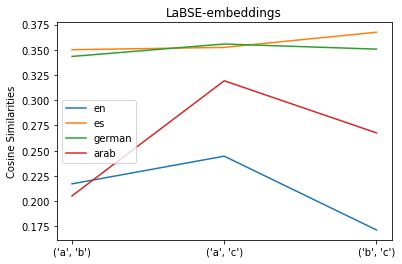

In [29]:
comb = combinations(['a','b','c'],2)
plt.plot(LaBSE_en)
plt.plot(LaBSE_es)
plt.plot(LaBSE_ger)
plt.plot(LaBSE_arab)
# plt.xlabel('Different sentence combinations')
plt.ylabel('Cosine Similarities')
plt.xticks(np.arange(0,3),comb)
plt.title('LaBSE-embeddings')
plt.legend(['en','es','german','arab'])